In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np

## Single Datacenter Ping Test analysis

In [2]:
# Get all file names.
do_file_names = glob.glob("./pings_intra_dc/do-pings/*.txt")
azure_file_names = glob.glob("./pings_intra_dc/azure-pings/*.txt")
aws_file_names = glob.glob("./pings_intra_dc/aws-pings-1/*.txt")
aws_file_names_2 = glob.glob("./pings_intra_dc/aws-pings-2/*.txt")
gcp_file_names = glob.glob("./pings_intra_dc/gcp-pings/*.txt")

In [3]:
# Helper functions

# takes in a file path to the log file and return ([list of latencies], packet loss in %, [list of 1's and 0's where
# 1 represents a packet loss for that particular ping. this list will have length 500.])
def scrap_ping_log(path):
    f = open(path).readlines()
    latencies = []
    packet_loss_positions = []
    packet_loss = 0
    curr_seq = 0
    # assuming the file is non empty.
    for l in f:
        if len(l) > 10 and l[0:2] == '64':
            time_idx = l.find("time=")
            latency = float(l[time_idx+5:-3])
            latencies.append(latency)
            seq_idx = l.find("icmp_seq=")
            ttl_idx = l.find("ttl=")
            seq = int(l[seq_idx+9:ttl_idx-1])
            if seq == curr_seq + 1:
                packet_loss_positions.append(0)
            else:
                print("Packet loss in {} at seq {}".format(path, curr_seq))
                for i in range(seq - curr_seq - 1):
                    packet_loss_positions.append(1)
                packet_loss_positions.append(0)
            curr_seq = seq
        elif len(l) > 10 and l[0:3] == '500':
            loss_line = l.split(",")[2].strip()
            percent_idx = loss_line.find("%")
            packet_loss = float(loss_line[:percent_idx])
            break
    return (latencies, packet_loss, packet_loss_positions)

# takes in a file path to the log file and returns an integer between 0 and 24 representing the time of test (UTC).
def get_log_time(path):
    path = path.split("/")[-1]
    timestamp = path.split("_")[1]
    hour = timestamp.split("-")[0]
    return int(hour)

# takes in a list of file paths to all the logs for a particular cloud provider and return 
# (ping_latencies, ping_losses, ping_loss_idx)
# where ping_latencies is dictionary: 
# key = hour, value = list of 500 ping latencies for that hour
# and ping_losses is dictionary:
# key = hour, value = % loss for that hour
# and ping_loss_idx is a dictionary:
# key = hour, value = list of 500 elements where element i is a 1 if the ith ping in that hour 
# resulted in a packet loss, else 0.
def create_data_dicts(log_paths):
    ping_latencies = {}
    ping_losses = {}
    ping_loss_idx = {}
    for i in log_paths:
        hour = get_log_time(i)
        data = scrap_ping_log(i)
        ping_latencies[hour] = data[0]
        ping_losses[hour] = data[1]
        ping_loss_idx[hour] = data[2]
    return (ping_latencies, ping_losses, ping_loss_idx)


# takes in a dictionary (idx 0 of tuple returned by create_data_dicts)) and plots a scatterplot of latencies vs hour
def create_ping_scatter_plot(latencies_dict, cloud_provider, is_wan=False):
    if is_wan:
        for i in range(1,8):
            y = latencies_dict[i]
            plt.scatter([i] * len(y), y)
        plt.xlabel("Hour of Day (CST)")
        plt.title("{} WAN Ping Test".format(cloud_provider))
        plt.xticks(range(1, 8, 1))
    else:
        for xe, ye in zip(latencies_dict.keys(), latencies_dict.values()):
            plt.scatter([xe] * len(ye), ye)
        plt.xlabel("Hour of Day (PST)")
        plt.title("{} Single D.C. Ping Test".format(cloud_provider))
        plt.xticks(range(0, 24, 1))
    #plt.yticks(np.arange(0, 1,0.1))
    plt.ylabel("Latency (ms)")
    plt.show()
    return

def create_avg_and_std_line_plots(latencies_dict, cloud_provider, is_wan=False):
    if is_wan:
        plt.plot(range(1, 8, 1), [np.mean(latencies_dict[i]) for i in range(1, 8)], label="avg latency")
        plt.plot(range(1, 8, 1), [np.std(latencies_dict[i]) for i in range(1, 8)], label="std dev")
        plt.xlabel("Hour of Day (CST)")
        plt.xticks(range(0, 8, 1))
        plt.title("{} WAN Ping Test".format(cloud_provider))
    else:
        plt.plot(range(24), [np.mean(latencies_dict[i]) for i in range(24)], label="avg latency")
        plt.plot(range(24), [np.std(latencies_dict[i]) for i in range(24)], label="std dev")
        plt.xlabel("Hour of Day (UTC)")
        plt.xticks(range(0, 24, 1))
        plt.title("{} Single D.C. Ping Test".format(cloud_provider))
    plt.ylabel("Avg Latency / Std Dev (ms)")
    
    plt.legend()
    plt.show()
    return
        
# plots the latencies of the 500 pings in a single hour in order, to see if the latency spikes follow some 
# pattern.
def create_inorder_plot(latencies_list, cloud_provider, hour):
    plt.plot(range(len(latencies_list)), latencies_list)
    plt.xlabel("Index of Ping at {} hour".format(hour))
    plt.ylabel("Latency (ms)")
    plt.title("{} Single D.C. Ping Test at {} hour".format(cloud_provider, hour))
    plt.show()
    return



In [4]:
do_ping_latencies, do_ping_losses, do_ping_loss_idx = create_data_dicts(do_file_names)
azure_ping_latencies, azure_ping_losses, azure_ping_loss_idx = create_data_dicts(azure_file_names)
aws_ping_latencies, aws_ping_losses, aws_ping_loss_idx = create_data_dicts(aws_file_names)
aws_ping_latencies_2, aws_ping_losses_2, aws_ping_loss_idx_2 = create_data_dicts(aws_file_names_2)
gcp_ping_latencies, gcp_ping_losses, gcp_ping_loss_idx = create_data_dicts(gcp_file_names)

Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_22-35-01_ping.txt at seq 269
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 42
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 63
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 249
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 270
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 312
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-12_23-35-01_ping.txt at seq 487
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-13_00-35-01_ping.txt at seq 19
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-13_00-35-01_ping.txt at seq 153
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-13_00-35-01_ping.txt at seq 201
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-13_00-35-01_ping.txt at seq 222
Packet loss in ./pings_intra_dc/aws-pings-1/2021-04-13_00-35-01_ping.txt at seq

### Digital Ocean

#### Latency

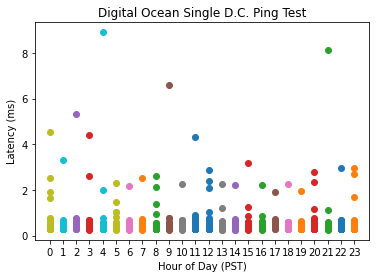

In [5]:
create_ping_scatter_plot(do_ping_latencies, "Digital Ocean")

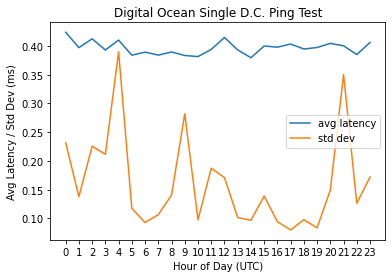

In [6]:
create_avg_and_std_line_plots(do_ping_latencies, "Digital Ocean")

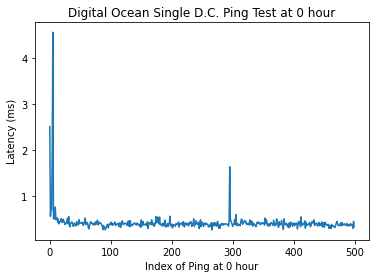

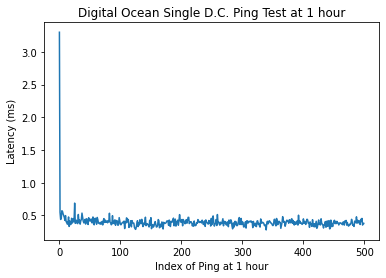

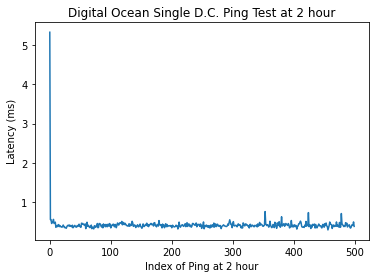

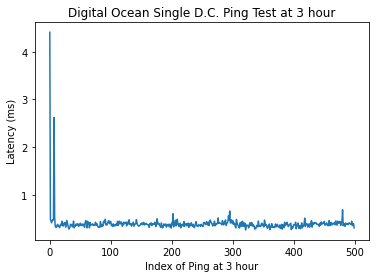

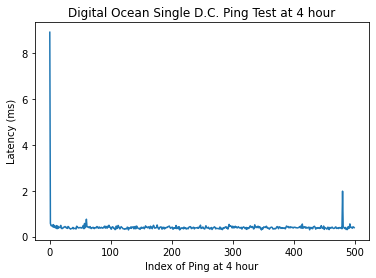

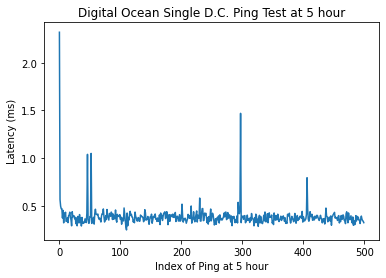

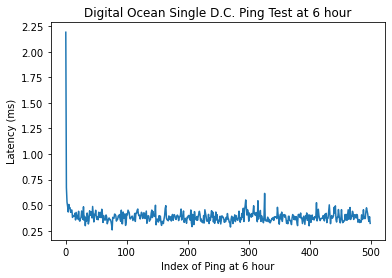

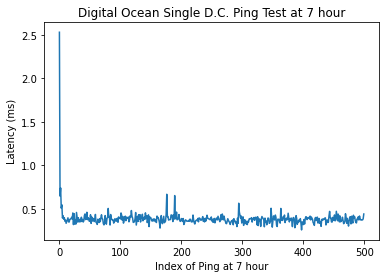

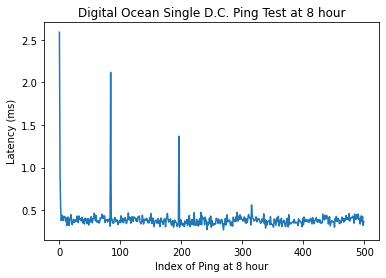

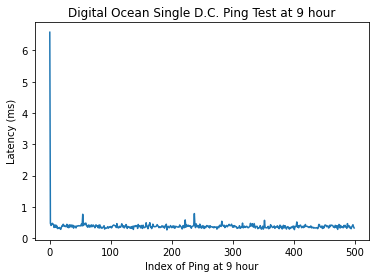

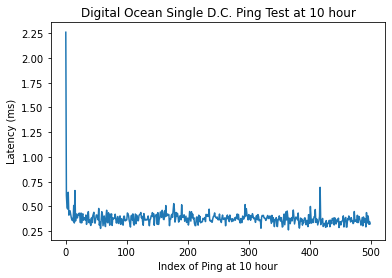

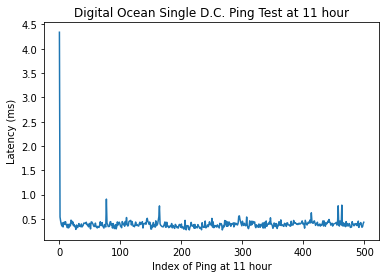

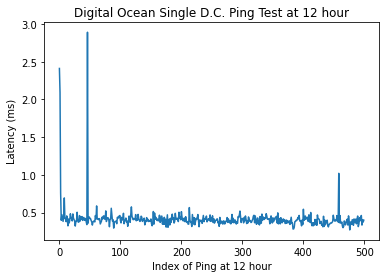

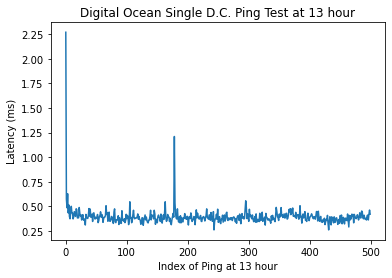

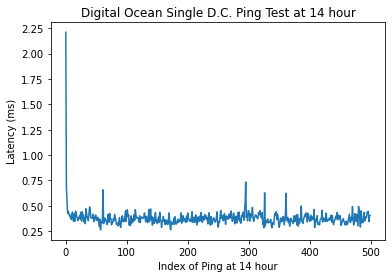

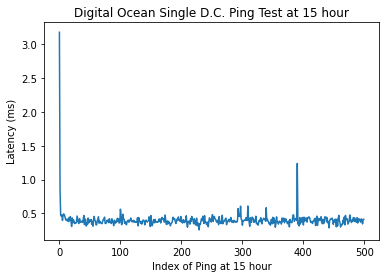

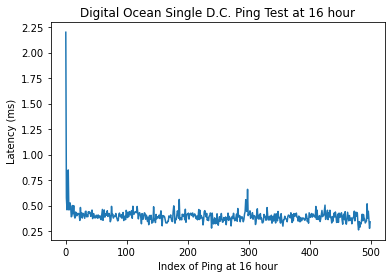

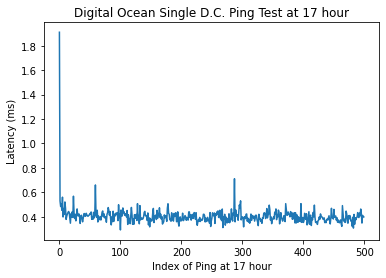

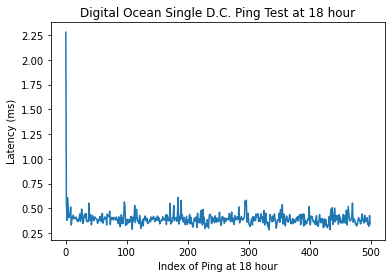

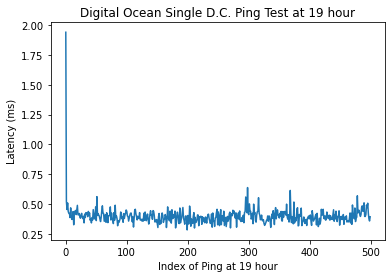

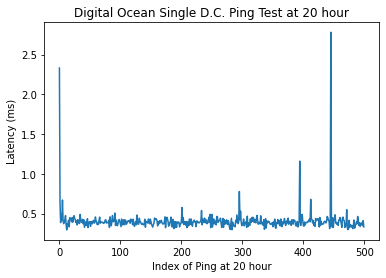

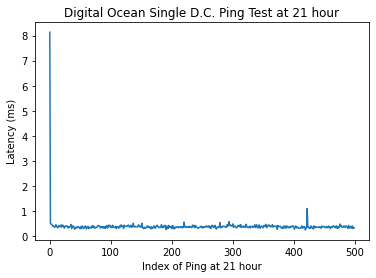

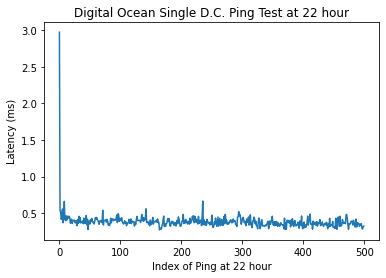

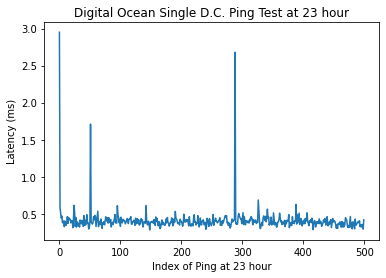

In [7]:
for h in range(24):
    create_inorder_plot(do_ping_latencies[h], "Digital Ocean", h)

### Azure

#### Latency

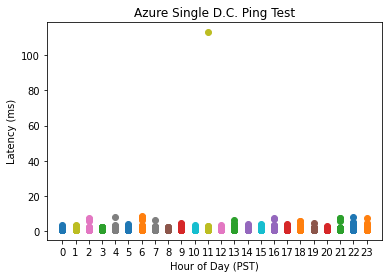

In [8]:
create_ping_scatter_plot(azure_ping_latencies, "Azure")

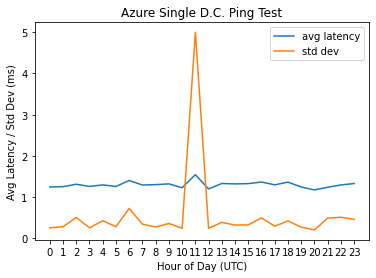

In [9]:
create_avg_and_std_line_plots(azure_ping_latencies, "Azure")

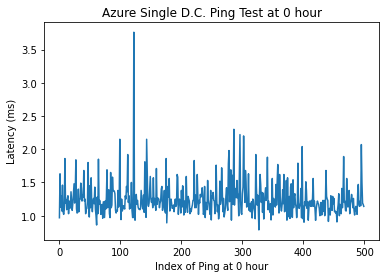

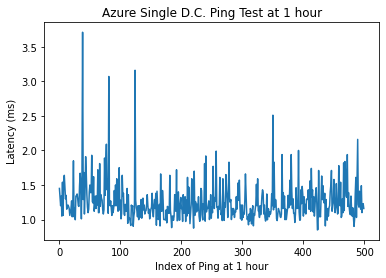

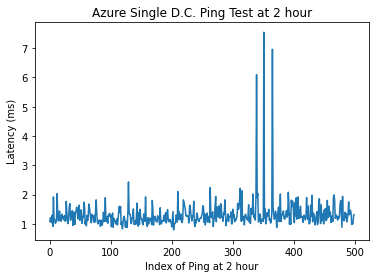

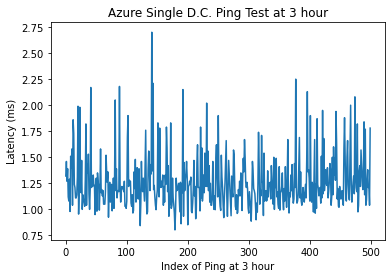

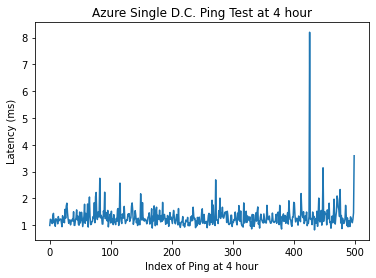

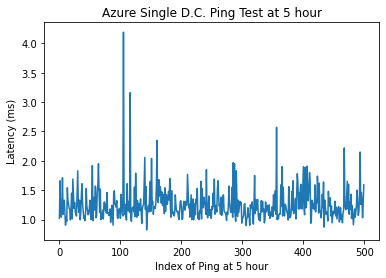

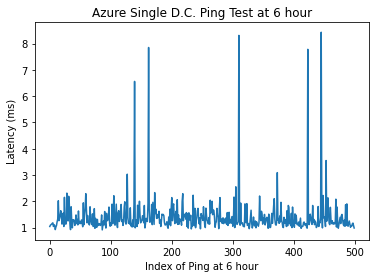

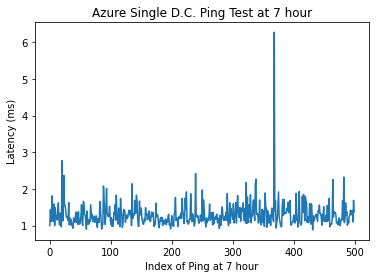

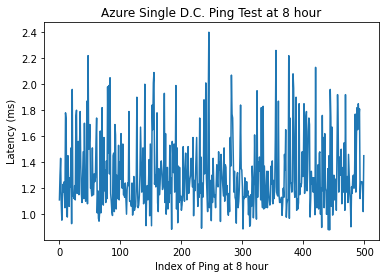

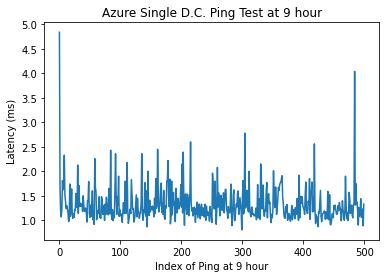

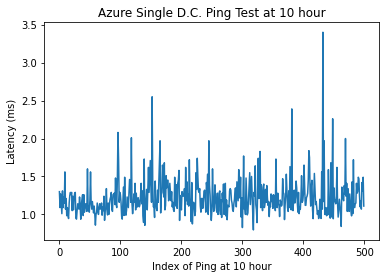

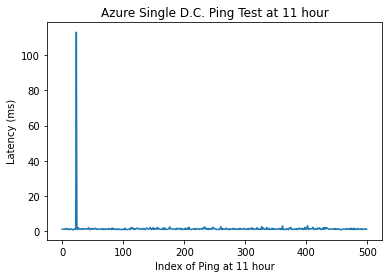

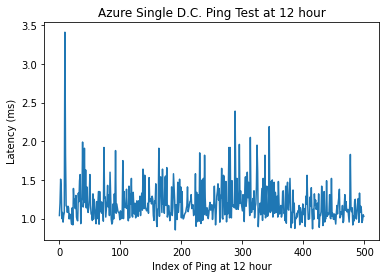

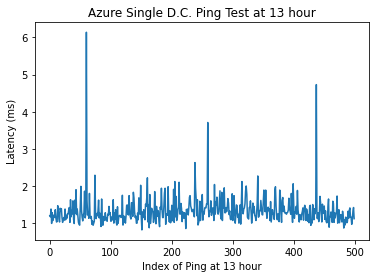

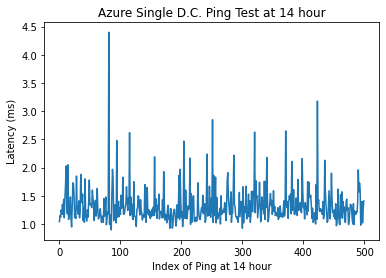

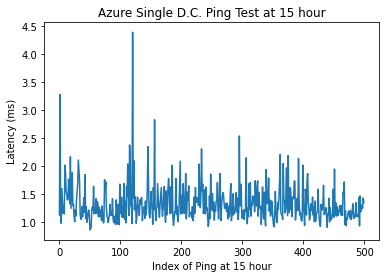

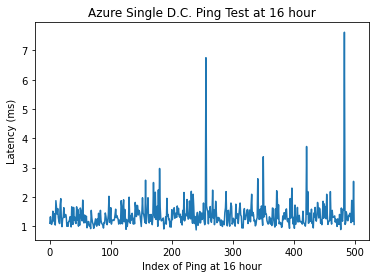

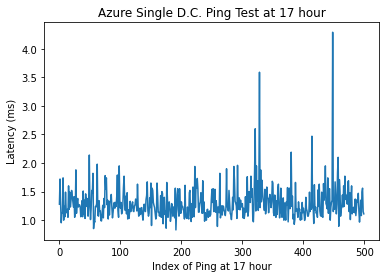

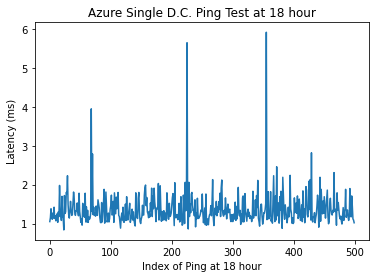

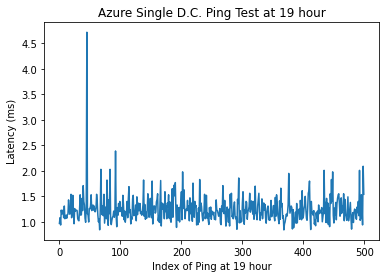

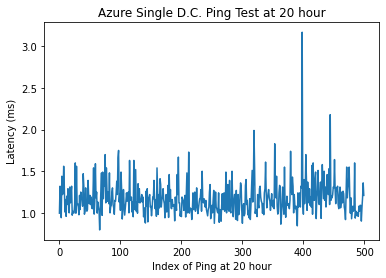

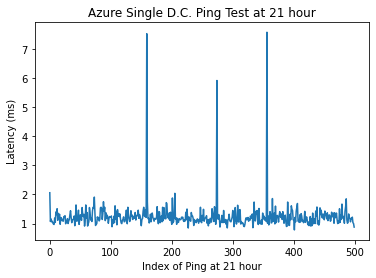

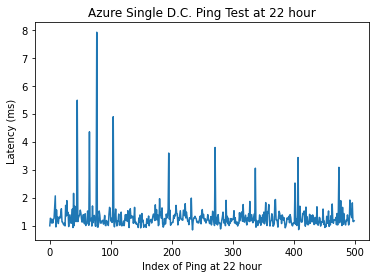

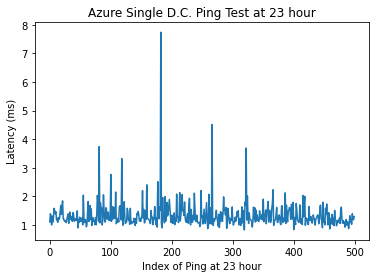

In [10]:
for h in range(24):
    create_inorder_plot(azure_ping_latencies[h], "Azure", h)

### AWS

#### Latency

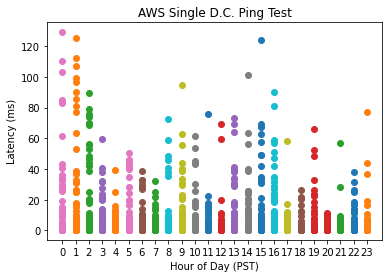

In [11]:
create_ping_scatter_plot(aws_ping_latencies, "AWS")

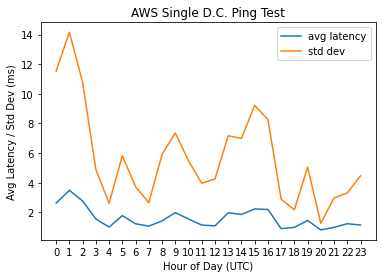

In [12]:
create_avg_and_std_line_plots(aws_ping_latencies, "AWS")

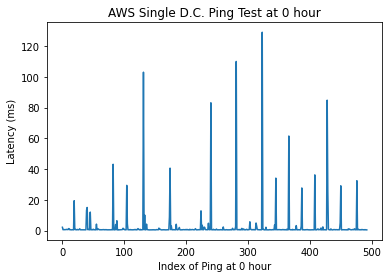

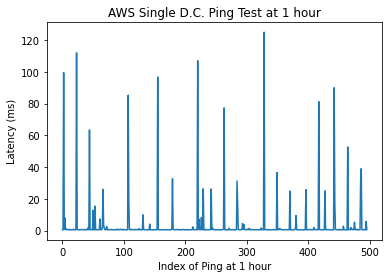

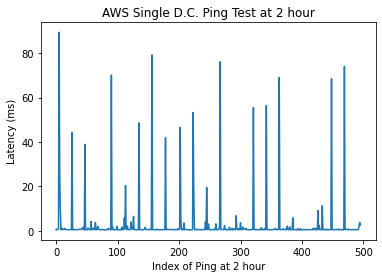

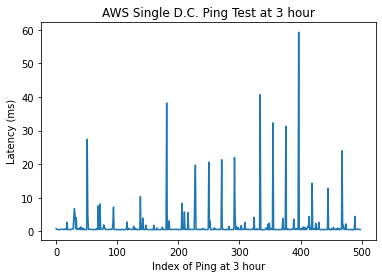

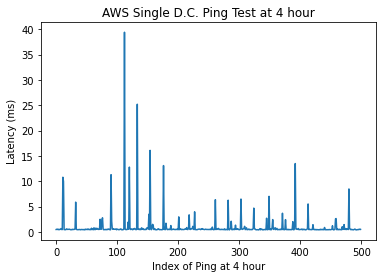

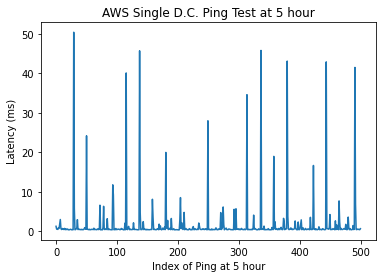

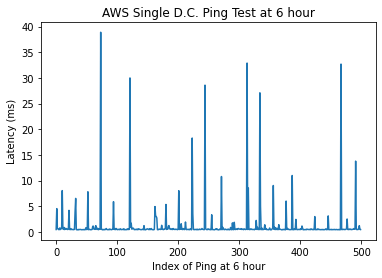

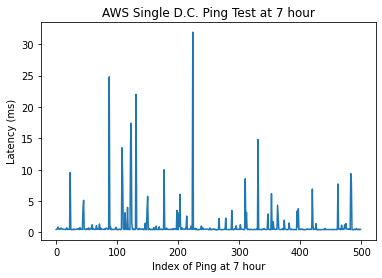

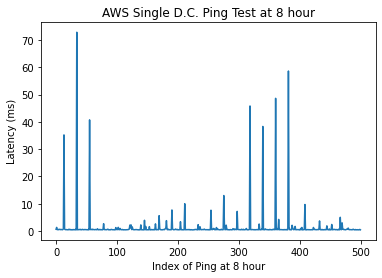

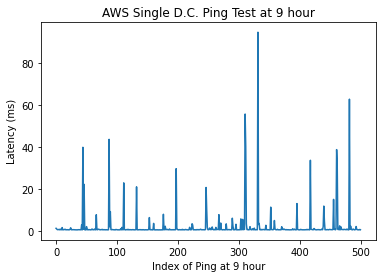

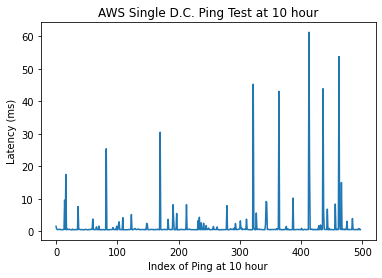

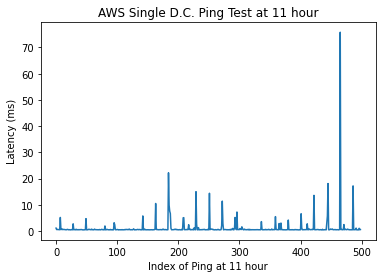

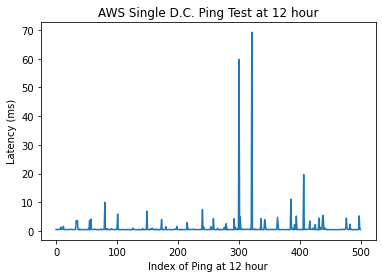

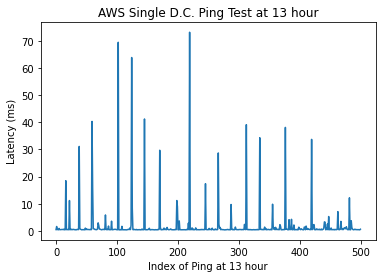

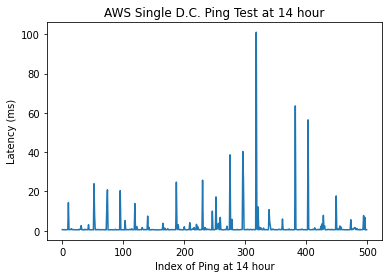

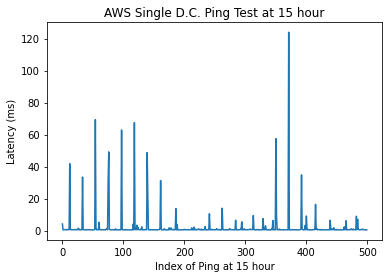

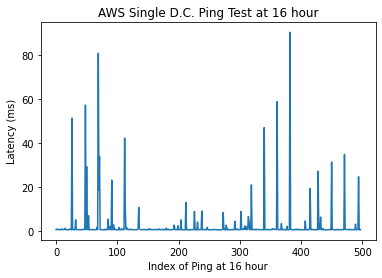

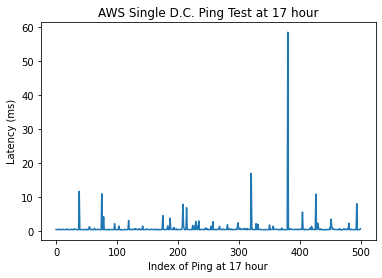

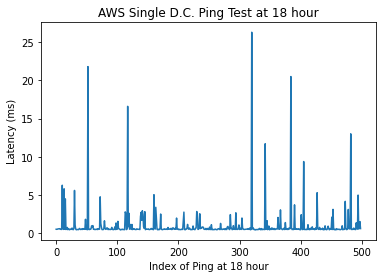

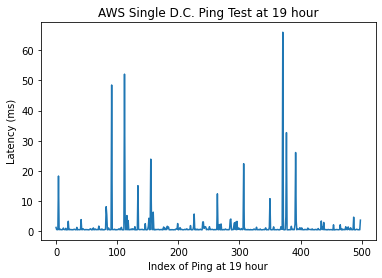

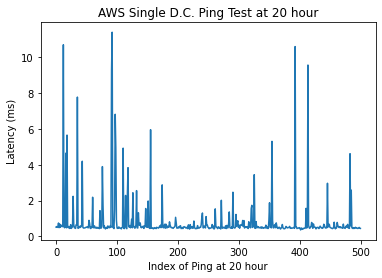

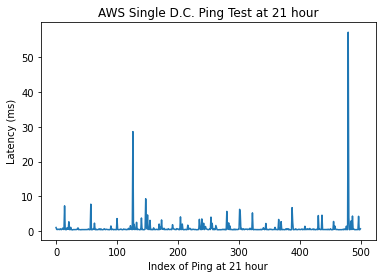

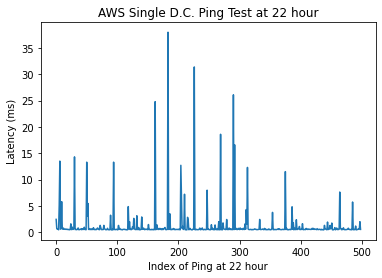

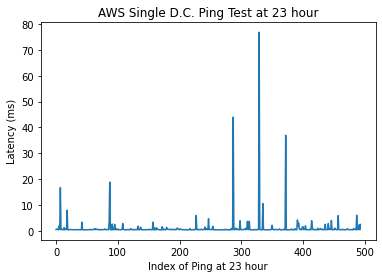

In [13]:
for h in range(24):
    create_inorder_plot(aws_ping_latencies[h], "AWS", h)

### GCP

#### Latency

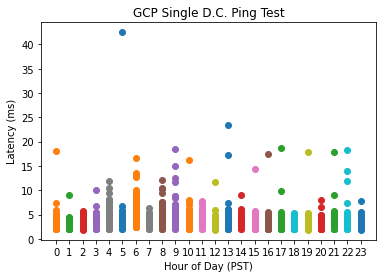

In [14]:
create_ping_scatter_plot(gcp_ping_latencies, "GCP")

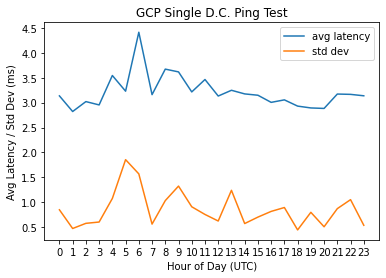

In [15]:
create_avg_and_std_line_plots(gcp_ping_latencies, "GCP")

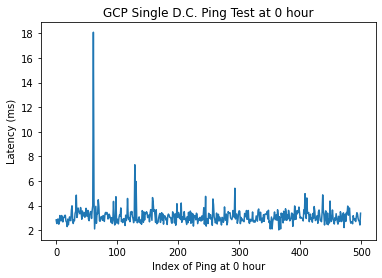

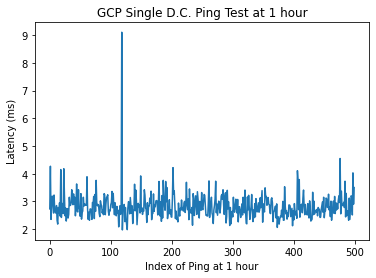

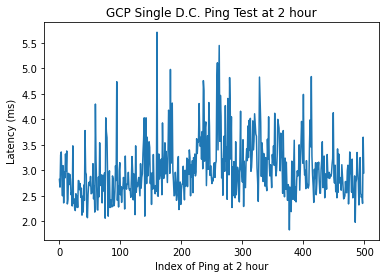

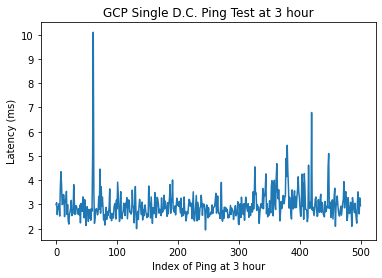

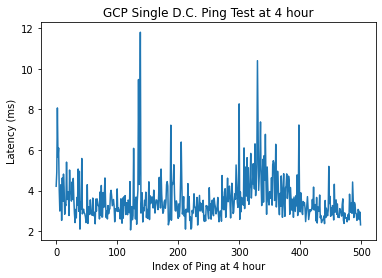

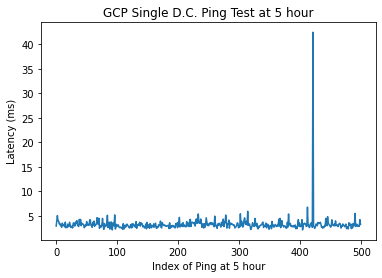

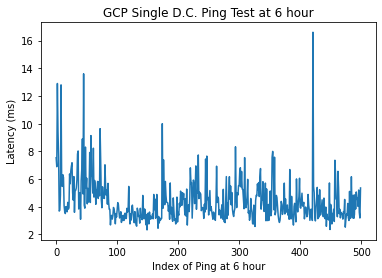

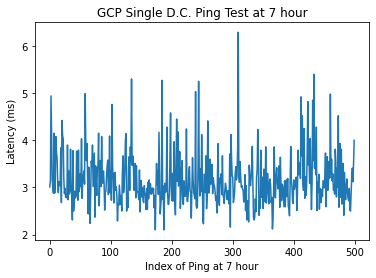

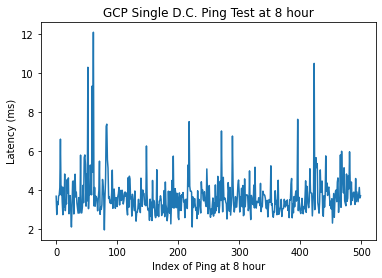

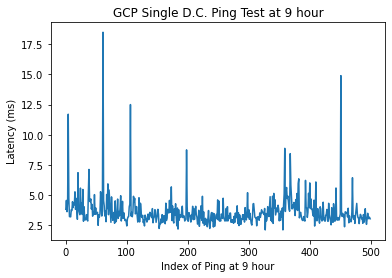

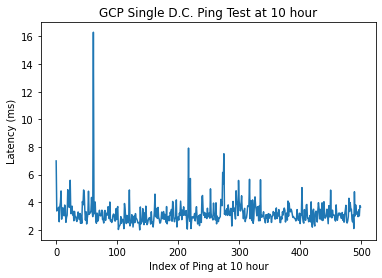

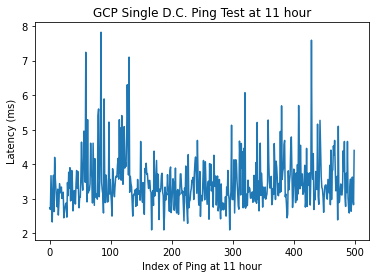

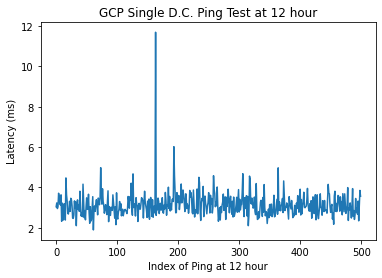

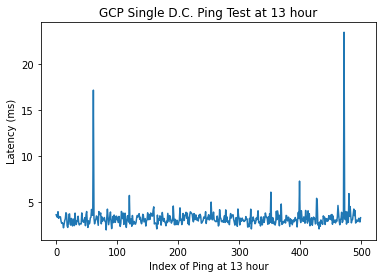

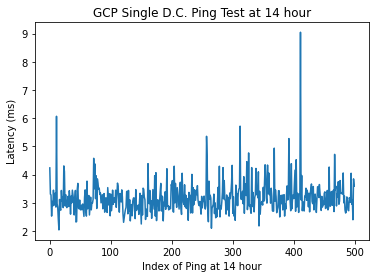

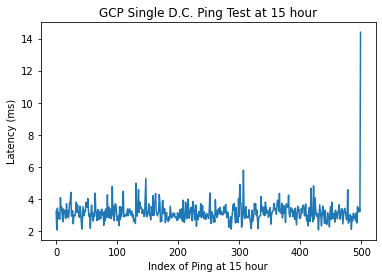

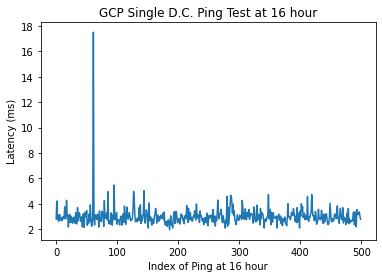

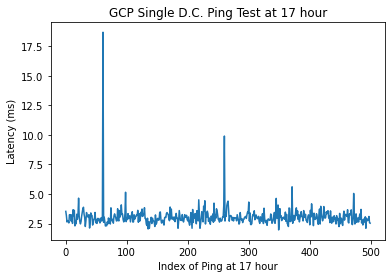

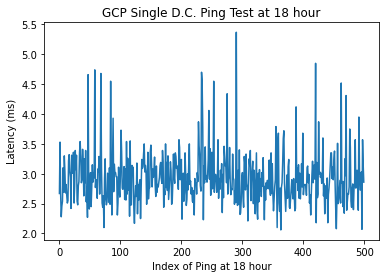

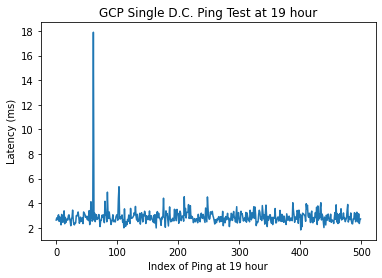

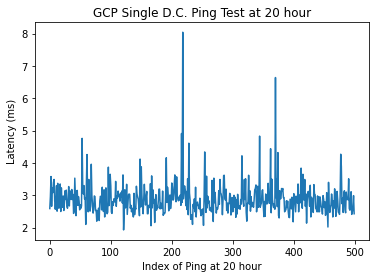

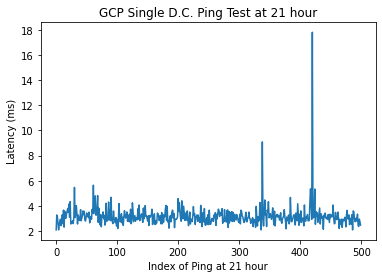

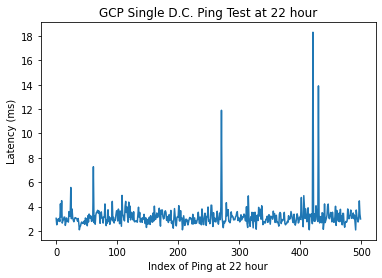

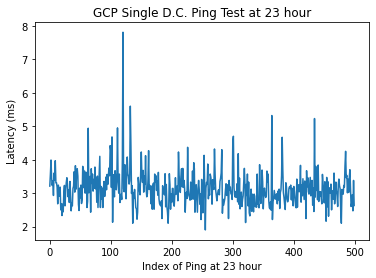

In [16]:
for h in range(24):
    create_inorder_plot(gcp_ping_latencies[h], "GCP", h)

## Combined Avg Latency & Std Dev Across Clouds

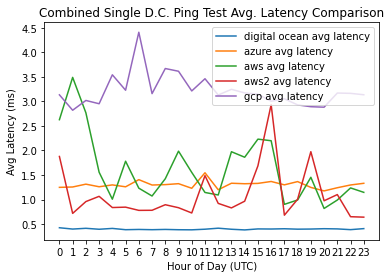

In [17]:
plt.plot(range(24), [np.mean(do_ping_latencies[i]) for i in range(24)], label="digital ocean avg latency")
plt.plot(range(24), [np.mean(azure_ping_latencies[i]) for i in range(24)], label="azure avg latency")
plt.plot(range(24), [np.mean(aws_ping_latencies[i]) for i in range(24)], label="aws avg latency")
plt.plot(range(24), [np.mean(aws_ping_latencies_2[i]) for i in range(24)], label="aws2 avg latency")
plt.plot(range(24), [np.mean(gcp_ping_latencies[i]) for i in range(24)], label="gcp avg latency")
plt.xlabel("Hour of Day (UTC)")
plt.xticks(range(0, 24, 1))
plt.title("Combined Single D.C. Ping Test Avg. Latency Comparison")
plt.ylabel("Avg Latency (ms)") 
plt.legend()
plt.show()

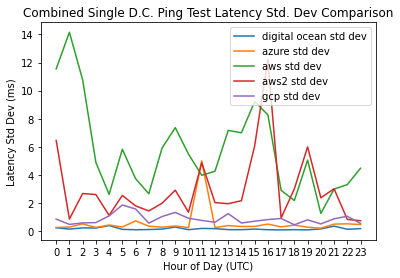

In [18]:
plt.plot(range(24), [np.std(do_ping_latencies[i]) for i in range(24)], label="digital ocean std dev")
plt.plot(range(24), [np.std(azure_ping_latencies[i]) for i in range(24)], label="azure std dev")
plt.plot(range(24), [np.std(aws_ping_latencies[i]) for i in range(24)], label="aws std dev")
plt.plot(range(24), [np.std(aws_ping_latencies_2[i]) for i in range(24)], label="aws2 std dev")
plt.plot(range(24), [np.std(gcp_ping_latencies[i]) for i in range(24)], label="gcp std dev")
plt.xlabel("Hour of Day (UTC)")
plt.xticks(range(0, 24, 1))
plt.title("Combined Single D.C. Ping Test Latency Std. Dev Comparison")
plt.ylabel("Latency Std Dev (ms)") 
plt.legend()
plt.show()

## Loss

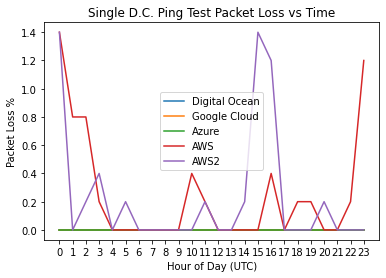

In [19]:
plt.plot(range(24), [do_ping_losses[i] for i in range(24)], label="Digital Ocean")
plt.plot(range(24), [gcp_ping_losses[i] for i in range(24)], label="Google Cloud")
plt.plot(range(24), [azure_ping_losses[i] for i in range(24)], label="Azure")
plt.plot(range(24), [aws_ping_losses[i] for i in range(24)], label="AWS")
plt.plot(range(24), [aws_ping_losses_2[i] for i in range(24)], label="AWS2")
plt.xlabel("Hour of Day (UTC)")
plt.xticks(range(0, 24, 1))
plt.ylabel("Packet Loss %")
plt.legend()
plt.title("Single D.C. Ping Test Packet Loss vs Time")
plt.show()

0


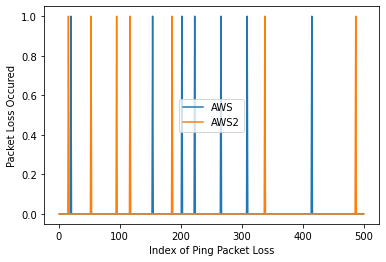

1


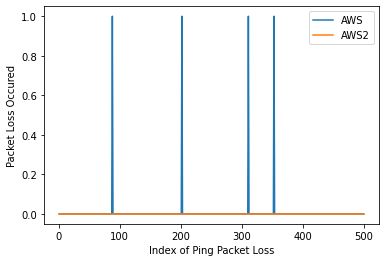

2


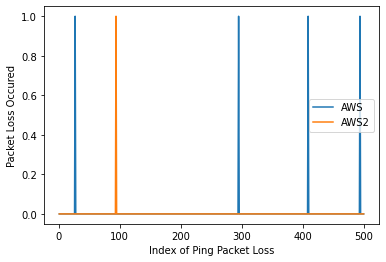

3


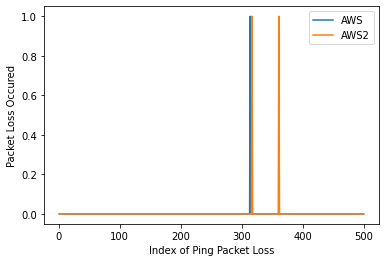

4


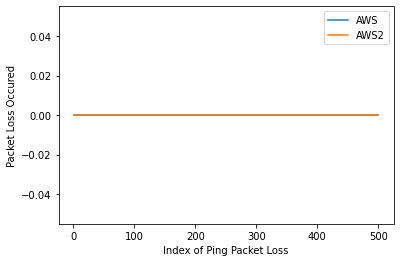

5


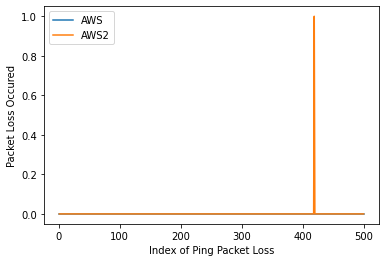

6


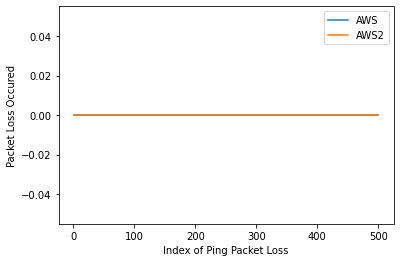

7


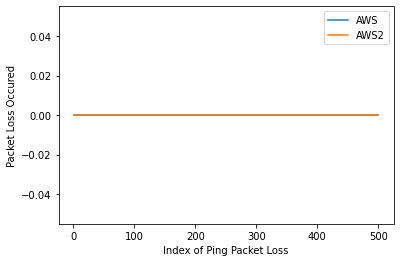

8


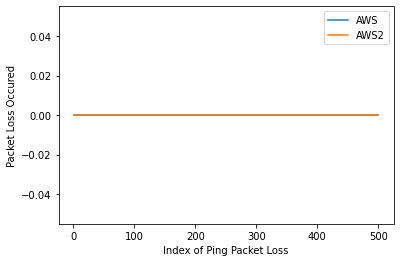

9


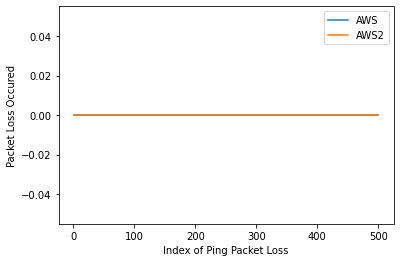

10


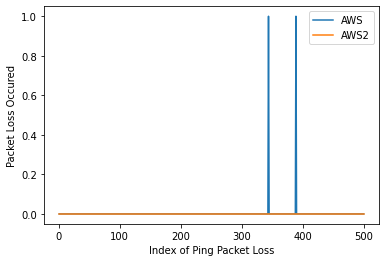

11


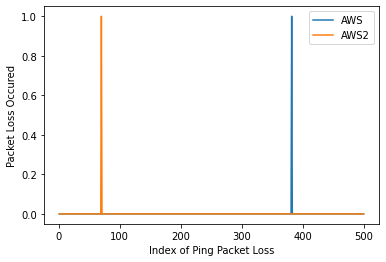

12


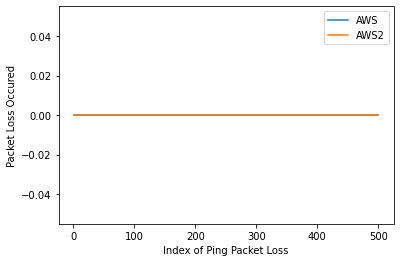

13


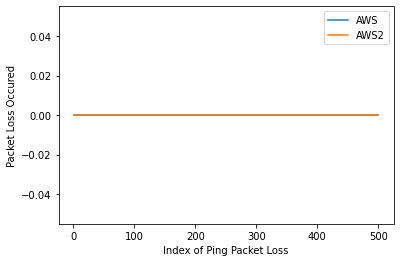

14


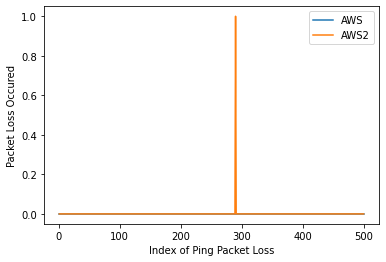

15


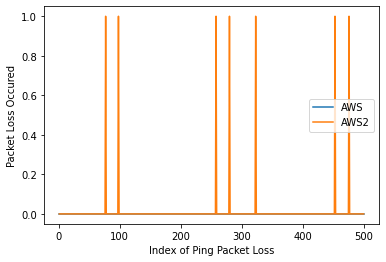

16


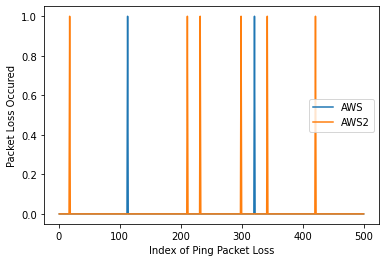

17


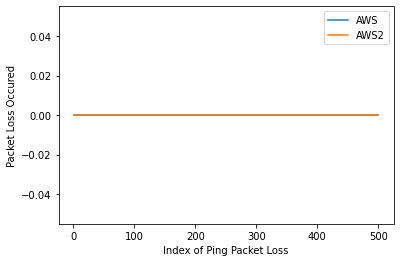

18


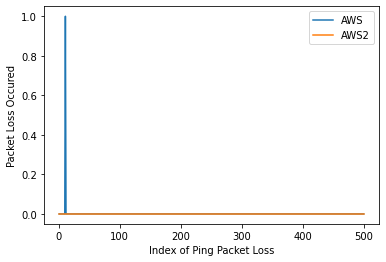

19


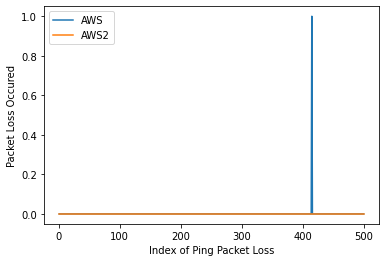

20


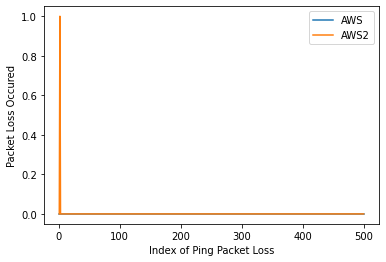

21


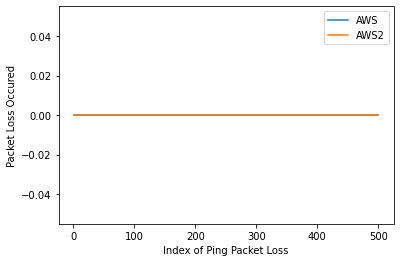

22


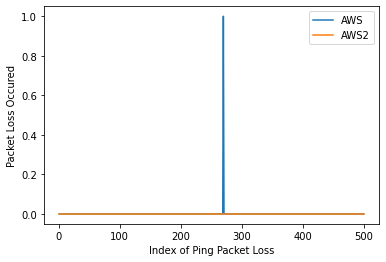

23


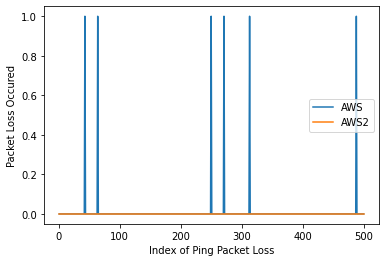

In [20]:
# Let's explore AWS' loss in-depth by doing an hour-by-hour in-order plot of the packet loss to see
# if there are patterns in the packet loss.
for h in range(24):
    print(h)
    plt.plot(range(1, 501), aws_ping_loss_idx[h], label="AWS")
    plt.plot(range(1, 501), aws_ping_loss_idx_2[h], label="AWS2")
    plt.xlabel("Index of Ping Packet Loss")
    plt.ylabel("Packet Loss Occured")
    plt.legend()
    plt.show()

## Wide Area Network Ping Test

In [21]:
# Get all file names.
do_wan_file_names = glob.glob("./pings_wan/do/*.txt")
azure_wan_file_names = glob.glob("./pings_wan/azure/*.txt")
aws_wan_file_names = glob.glob("./pings_wan/aws/*.txt")
gcp_wan_file_names = glob.glob("./pings_wan/gcp/*.txt")

In [23]:
do_wan_ping_latencies, do_wan_ping_losses, do_ping_loss_idx = create_data_dicts(do_wan_file_names)
azure_wan_ping_latencies, azure_wan_ping_losses, azure_ping_loss_idx = create_data_dicts(azure_wan_file_names)
aws_wan_ping_latencies, aws_wan_ping_losses, aws_ping_loss_idx = create_data_dicts(aws_wan_file_names)
gcp_wan_ping_latencies, gcp_wan_ping_losses, gcp_ping_loss_idx = create_data_dicts(gcp_wan_file_names)

Packet loss in ./pings_wan/do/2021-04-15_22-43-00_ping.txt at seq 0
Packet loss in ./pings_wan/do/2021-04-15_22-43-00_ping.txt at seq 142
Packet loss in ./pings_wan/do/2021-04-15_22-43-00_ping.txt at seq 422
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 0
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 135
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 163
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 269
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 310
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 406
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 440
Packet loss in ./pings_wan/do/2021-04-15_23-43-00_ping.txt at seq 461
Packet loss in ./pings_wan/do/2021-04-15_21-43-00_ping.txt at seq 0
Packet loss in ./pings_wan/do/2021-04-15_21-43-00_ping.txt at seq 137
Packet loss in ./pings_wan/do/2021-04-15_20-43-01_ping.txt at seq 0
Packet loss in ./pings_wan/d

### Digital Ocean

#### Latency

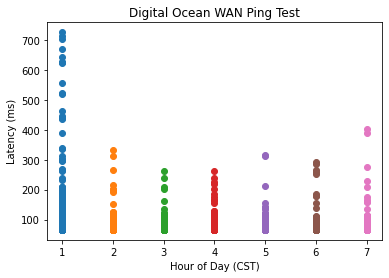

In [24]:
create_ping_scatter_plot(do_wan_ping_latencies, "Digital Ocean", True)

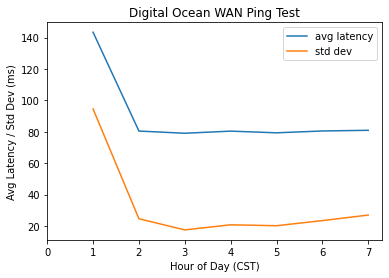

In [25]:
create_avg_and_std_line_plots(do_wan_ping_latencies, "Digital Ocean", True)

### Azure

#### Latency

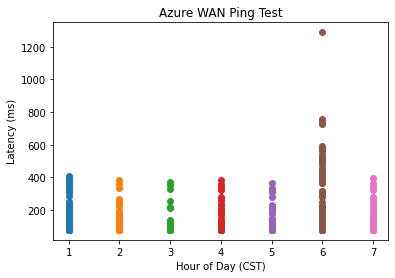

In [26]:
create_ping_scatter_plot(azure_wan_ping_latencies, "Azure", True)

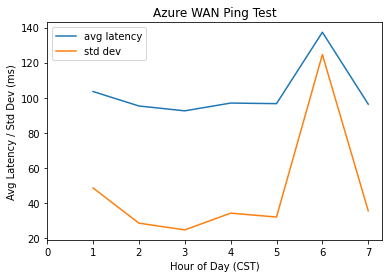

In [27]:
create_avg_and_std_line_plots(azure_wan_ping_latencies, "Azure", True)

### AWS

#### Latency

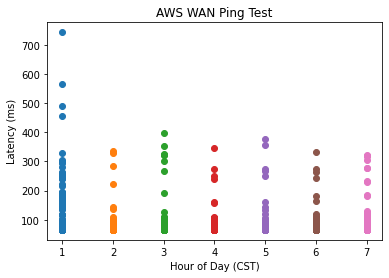

In [28]:
create_ping_scatter_plot(aws_wan_ping_latencies, "AWS", True)

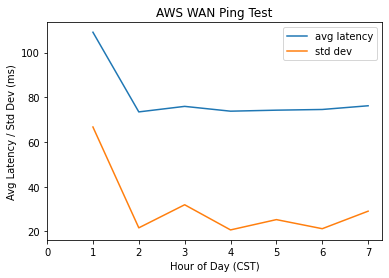

In [29]:
create_avg_and_std_line_plots(aws_wan_ping_latencies, "AWS", True)

### GCP

#### Latency

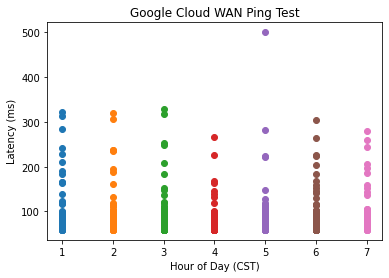

In [30]:
create_ping_scatter_plot(gcp_wan_ping_latencies, "Google Cloud", True)

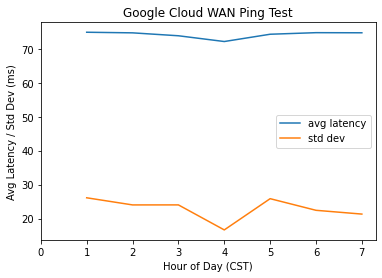

In [31]:
create_avg_and_std_line_plots(gcp_wan_ping_latencies, "Google Cloud", True)

## Combined Avg Latency & Std Dev Across Clouds

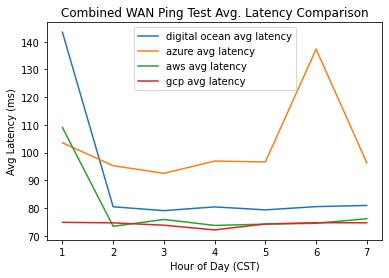

In [32]:
plt.plot(range(1,8), [np.mean(do_wan_ping_latencies[i]) for i in range(1,8)], label="digital ocean avg latency")
plt.plot(range(1,8), [np.mean(azure_wan_ping_latencies[i]) for i in range(1,8)], label="azure avg latency")
plt.plot(range(1,8), [np.mean(aws_wan_ping_latencies[i]) for i in range(1,8)], label="aws avg latency")
plt.plot(range(1,8), [np.mean(gcp_wan_ping_latencies[i]) for i in range(1,8)], label="gcp avg latency")
plt.xlabel("Hour of Day (CST)")
plt.xticks(range(1, 8, 1))
plt.title("Combined WAN Ping Test Avg. Latency Comparison")
plt.ylabel("Avg Latency (ms)") 
plt.legend()
plt.show()

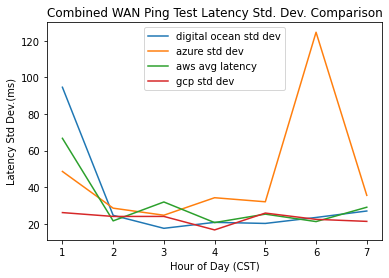

In [33]:
plt.plot(range(1,8), [np.std(do_wan_ping_latencies[i]) for i in range(1,8)], label="digital ocean std dev")
plt.plot(range(1,8), [np.std(azure_wan_ping_latencies[i]) for i in range(1,8)], label="azure std dev")
plt.plot(range(1,8), [np.std(aws_wan_ping_latencies[i]) for i in range(1,8)], label="aws avg latency")
plt.plot(range(1,8), [np.std(gcp_wan_ping_latencies[i]) for i in range(1,8)], label="gcp std dev")
plt.xlabel("Hour of Day (CST)")
plt.xticks(range(1, 8, 1))
plt.title("Combined WAN Ping Test Latency Std. Dev. Comparison")
plt.ylabel("Latency Std Dev.(ms)") 
plt.legend()
plt.show()

## Loss

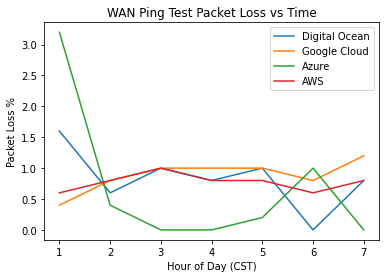

In [34]:
plt.plot(range(1,8), [do_wan_ping_losses[i] for i in range(1,8)], label="Digital Ocean")
plt.plot(range(1,8), [gcp_wan_ping_losses[i] for i in range(1,8)], label="Google Cloud")
plt.plot(range(1,8), [azure_wan_ping_losses[i] for i in range(1,8)], label="Azure")
plt.plot(range(1,8), [aws_wan_ping_losses[i] for i in range(1,8)], label="AWS")
plt.xlabel("Hour of Day (CST)")
plt.xticks(range(1, 8, 1))
plt.ylabel("Packet Loss %")
plt.legend()
plt.title("WAN Ping Test Packet Loss vs Time")
plt.show()